In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import os

In [3]:
#os.chdir('D:\\Masters Thesis\\Masters Thesis B\\Thesis project')

In [4]:
df_1 = pd.read_csv('banknifty.csv')

In [5]:
df_1.head()

,index,date,time,open,high,low,close
0,BANKNIFTY,20121203,09:16,12125.70,12161.70,12125.70,12160.95
1,BANKNIFTY,20121203,09:17,12161.75,12164.80,12130.40,12130.40
2,BANKNIFTY,20121203,09:18,12126.85,12156.10,12126.85,12156.10
3,BANKNIFTY,20121203,09:19,12157.25,12164.75,12151.60,12164.20
4,BANKNIFTY,20121203,09:20,12162.80,12162.80,12148.20,12151.15


# Preprocessing Data

In [6]:
def Date_Time(dataFrame):
    dateTime = dataFrame['date'].map(str)+dataFrame['time']
    k = pd.to_datetime(dateTime, format='%Y%m%d%H:%M')
    dataFrame['DateTime'] = k
    
    dataFrame['Day'] = dataFrame['DateTime'].dt.day
    dataFrame['Month'] = dataFrame['DateTime'].dt.month
    dataFrame['Year'] = dataFrame['DateTime'].dt.year
    dataFrame['Hour'] = dataFrame['DateTime'].dt.hour
    dataFrame['Minute'] = dataFrame['DateTime'].dt.minute
    
    dataFrame = dataFrame.drop(labels=['DateTime'], axis=1)
    dataFrame['group']= dataFrame['Year'].map(str) + dataFrame['Month'].map(str)+ dataFrame['Day'].map(str) + dataFrame['Hour'].map(str)

    dataFrame = dataFrame[['open', 'high', 'low', 'Day', 'Month', 'Year', 'Hour',
       'Minute','group','close']]
    
    dataFrame= dataFrame.sort_values(by=['Year','Month','Day','Hour','Minute'])
    dataFrame= dataFrame.reset_index(drop=True)
    
    return(dataFrame)

In [7]:
def processing(dataframe):
    df = dataframe
    
    hour_group = df['group'].unique() # extract unique hour values to form group based on days, month and year
    h_group_index = np.arange(1,len(hour_group)+1)# for reindexing hour group values from 1 to number of groups.
    #As indexing starts from 0 so 1 is added
    
    # replacing hour group values with new indexing for extracting hour groups
    #(This step will take 20 minutes due to 3 hundred thousand samples)
    # it is already done once and results are saved in file hour.npy
    # so instead of running again, load this file
    '''
    for i in range(len(hour_group)):
        df['group'] = df['group'].replace([hour_group[i]],h_group_index[i])
    '''
    df['group'] = np.load('hours.npy')
        
    count_index = df['close'].groupby(df['group']).count() # counting each day group values
    
    hour_index = []  # extracting months index
    w=0
    for i in count_index:
        w = i+w
        hour_index.append(w)
    hour_index = np.array(hour_index) -1 # subtracting with -1 as indexing starts from 0 instead of 1
    # above steps are adding count values(in other words "commulative count_index") 
    # we need commulative count_index as count_index are absolute values from which required values cant be extracted
    
    # extracting close values which is last value of each month group
    close = []
    for i in hour_index:
        t = df.loc[i,'close']
        close.append(t)
    close = np.array(close)
    
    #extracting low, high, month, year values of each month group
    # index is resetted because extracted group values keeps previous dataframe indexes 
    low = pd.DataFrame(df['low'].groupby(df['group']).min()).reset_index(drop=True)
    high = pd.DataFrame(df['high'].groupby(df['group']).max()).reset_index(drop=True)
    Day = pd.DataFrame(df['Day'].groupby(df['group']).max()).reset_index(drop=True)
    Month = pd.DataFrame(df['Month'].groupby(df['group']).max()).reset_index(drop=True)
    Year = pd.DataFrame(df['Year'].groupby(df['group']).max()).reset_index(drop=True)
    Hour = pd.DataFrame(df['Hour'].groupby(df['group']).max()).reset_index(drop=True)
    
    #extracting first value of open from each month group
    openn = []
    for i in (hour_index-count_index+1):
        r = df.loc[i,'open']
        openn.append(r)
    openn = np.array(openn)
    
    #creating new data frame with extracted values 
    df2 = pd.DataFrame()
    
    df2['open'] = openn
    df2['high'] = high
    df2['low'] = low
    df2['Day'] = Day
    df2['Month'] = Month
    df2['Year'] = Year
    df2['Hour'] = Hour
    df2['close'] = close

    return(df2)

In [8]:
def scaling(dataFrame):
    
    close = np.array(dataFrame['close']).reshape(-1,1)
    stock_df = dataFrame.drop(labels=['close'], axis = 1)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(stock_df)
    scaled_df = scaler.transform(stock_df)
    
    scaler2 = MinMaxScaler(feature_range=(0,1))
    scaler2.fit(close)
    scaled_close = scaler2.transform(close)
    
    scaled_df = pd.DataFrame(scaled_df, columns=stock_df.columns)
    scaled_df['close'] = scaled_close
    
    return(scaled_df, scaler, scaler2)

In [9]:
stock_df1 = Date_Time(df_1)

In [10]:
stock_df1.head()

,open,high,low,Day,Month,Year,Hour,Minute,group,close
0,11276.55,11276.55,11265.80,1,11,2012,9,16,20121119,11268.90
1,11267.95,11267.95,11258.85,1,11,2012,9,17,20121119,11260.05
2,11259.45,11259.45,11243.90,1,11,2012,9,18,20121119,11243.90
3,11246.50,11246.60,11237.90,1,11,2012,9,19,20121119,11238.90
4,11241.15,11247.20,11239.30,1,11,2012,9,20,20121119,11245.30


In [11]:
stock_df1_1 = processing(stock_df1)

In [12]:
stock_df1_1.head()

,open,high,low,Day,Month,Year,Hour,close
0,11276.55,11320.65,11230.20,1,11,2012,9,11301.85
1,11303.30,11305.85,11255.25,1,11,2012,10,11267.00
2,11266.50,11344.90,11256.10,1,11,2012,11,11328.50
3,11324.40,11344.55,11317.35,1,11,2012,12,11327.45
4,11332.80,11349.40,11303.20,1,11,2012,13,11325.15


In [13]:
stock_df2, in_scaler, out_scaler = scaling(stock_df1_1)

In [14]:
stock_df2.head()

,open,high,low,Day,Month,Year,Hour,close
0,0.507543,0.508050,0.514885,0.0,0.909091,0.0,0.0,0.508640
1,0.508919,0.507291,0.516198,0.0,0.909091,0.0,0.1,0.506847
2,0.507026,0.509294,0.516242,0.0,0.909091,0.0,0.2,0.510011
3,0.510005,0.509276,0.519452,0.0,0.909091,0.0,0.3,0.509957
4,0.510437,0.509525,0.518710,0.0,0.909091,0.0,0.4,0.509838


# Data Plots

Time Series Distribution For Month


Text(0, 0.5, 'Stock Rate')

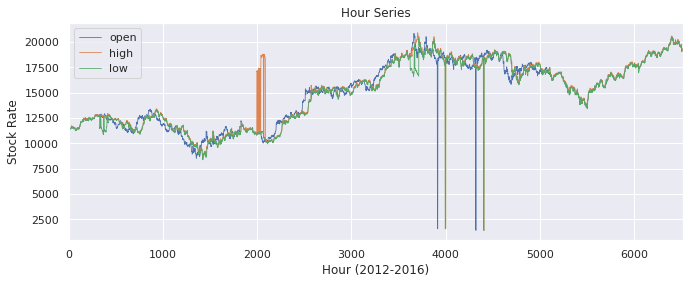

In [15]:
sns.set(rc={'figure.figsize':(11,4)})
stock_df1_1[['open','high','low']].plot(linewidth=0.8, title='Hour Series')
plt.xlabel('Hour (2012-2016)')
plt.ylabel('Stock Rate')

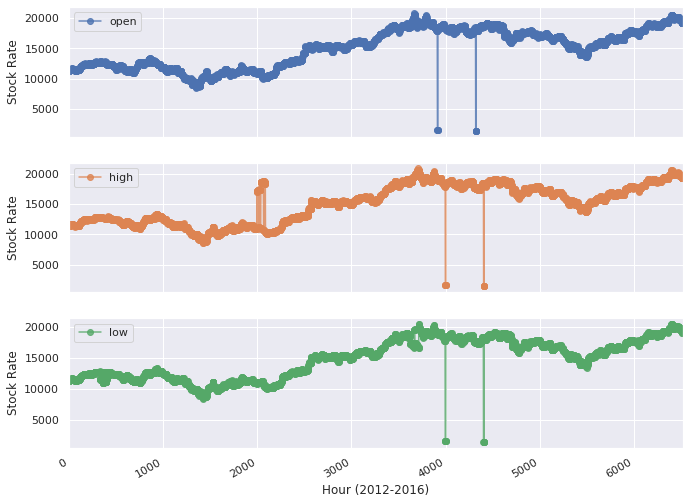

In [16]:
cols_plot = ['open', 'high','low']
axes = stock_df1_1[cols_plot].plot(marker='o', alpha=0.8, linestyle='-', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Stock Rate')
    ax.set_xlabel('Hour (2012-2016)')

Box Pots

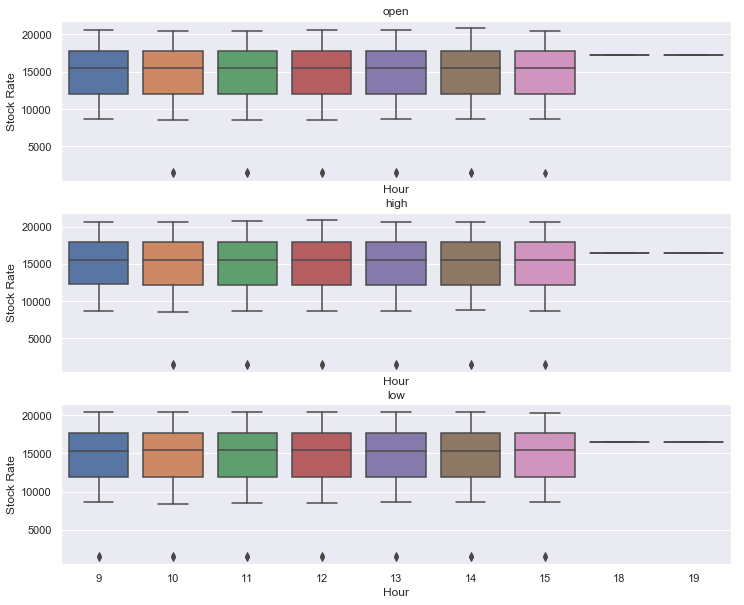

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
for name, ax in zip(['open', 'high', 'low'], axes):
    sns.boxplot(data=stock_df1_1, x='Hour', y=name, ax=ax)
    ax.set_ylabel('Stock Rate')
    ax.set_title(name)

Heat Map

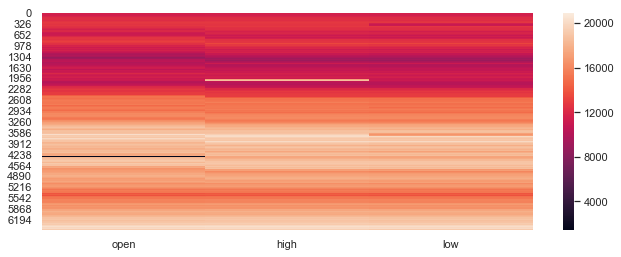

In [18]:
sns.heatmap(stock_df1_1[['open','high','low']])

Histograms and Curve Distribution

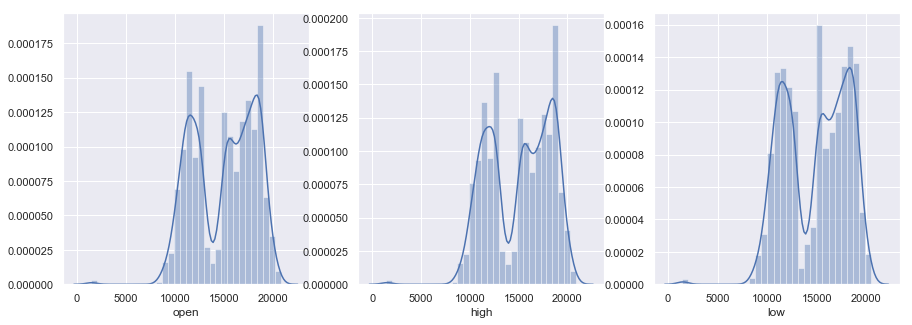

In [19]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
for name, ax in zip(['open', 'high', 'low'], axes):
    sns.distplot(stock_df1_1[name], ax=ax)

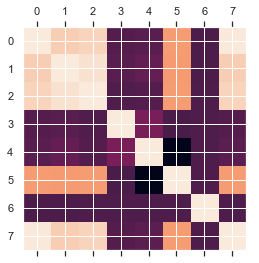

In [20]:
plt.matshow(stock_df1_1.corr())
plt.show()

Scatter Plot

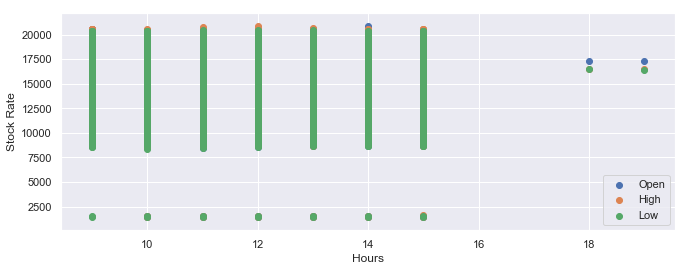

In [21]:
plt.scatter(stock_df1_1['Hour'],stock_df1_1['open'])
plt.scatter(stock_df1_1['Hour'],stock_df1_1['high'])
plt.scatter(stock_df1_1['Hour'],stock_df1_1['low'])
plt.legend(['Open','High','Low'])
plt.xlabel('Hours')
plt.ylabel('Stock Rate')
plt.show()

Trend

Text(0.5, 0, 'Hours')

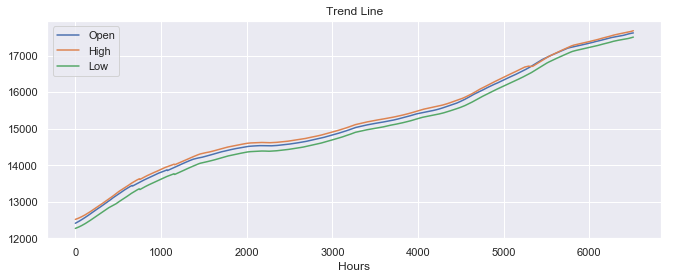

In [22]:
plt.plot(stock_df1_1['open'].rolling(window=6500, center=True, min_periods=30).mean())
plt.plot(stock_df1_1['high'].rolling(window=6500, center=True, min_periods=30).mean())
plt.plot(stock_df1_1['low'].rolling(window=6500, center=True, min_periods=30).mean())
plt.legend(['Open','High','Low'])
plt.title('Trend Line')
plt.xlabel('Hours')

# Splitting Data into Train/Test

In [17]:
def train_test_data(data):
    x = np.array(data.iloc[:,:-1])
    y = np.array(data.iloc[:,-1])
    
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, shuffle= True)
    
    return (x_train, x_test, y_train, y_test)

In [18]:
x_train_df1, x_test_df1, y_train_df1, y_test_df1 = train_test_data(stock_df2)

In [19]:
x_train_df1.shape

(5212, 7)

In [20]:
y_train_df1.shape

(5212,)

In [21]:
X_train_df1 = x_train_df1.reshape((x_train_df1.shape[0],1, x_train_df1.shape[1]))
X_test_df1 = x_test_df1.reshape((x_test_df1.shape[0],1, x_test_df1.shape[1]))

# GRU

In [22]:
from keras.layers import LSTM, GRU
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation

Using TensorFlow backend.


In [29]:
gru = Sequential()
gru.add(GRU(8, input_shape=(X_train_df1.shape[1], X_train_df1.shape[2])))
gru.add(Dense(2, activation='sigmoid'))
gru.add(Dense(y_train_df1.reshape(-1,1).shape[1]))

gru.compile(loss='mae', optimizer='adam', metrics=['mean_squared_error'])

In [30]:
gru.fit(X_train_df1, y_train_df1, epochs =10, verbose=1, batch_size=8,
          validation_data=(X_test_df1,y_test_df1), shuffle=True)

Train on 5212 samples, validate on 1304 samples
Epoch 1/10
5212/5212 [==============================] - 7s 1ms/step - loss: 0.1238 - mean_squared_error: 0.0248 - val_loss: 0.0591 - val_mean_squared_error: 0.0063
Epoch 2/10
5212/5212 [==============================] - 7s 1ms/step - loss: 0.0355 - mean_squared_error: 0.0028 - val_loss: 0.0189 - val_mean_squared_error: 0.0013
Epoch 3/10
5212/5212 [==============================] - 7s 1ms/step - loss: 0.0159 - mean_squared_error: 0.0012 - val_loss: 0.0138 - val_mean_squared_error: 8.7712e-04
Epoch 4/10
5212/5212 [==============================] - 7s 1ms/step - loss: 0.0126 - mean_squared_error: 9.5298e-04 - val_loss: 0.0109 - val_mean_squared_error: 6.3434e-04
Epoch 5/10
5212/5212 [==============================] - 6s 1ms/step - loss: 0.0111 - mean_squared_error: 8.5242e-04 - val_loss: 0.0105 - val_mean_squared_error: 4.9929e-04
Epoch 6/10
5212/5212 [==============================] - 7s 1ms/step - loss: 0.0097 - mean_squared_error: 7.4930e

In [31]:
predict = gru.predict(X_test_df1)

In [32]:
# Output value is scaled. To get actual value undo scaled value of output
print('Scaled Value Predicted: %.2f' %predict[2])
print('Actual Predicted Value: %.2f'%out_scaler.inverse_transform([predict[2]]))
print('True Value: %.2f' %out_scaler.inverse_transform([[y_test_df1[2]]]))

Scaled Value Predicted: 0.57
Actual Predicted Value: 12415.59
True Value: 12412.10


In [24]:
gru.save('gru.h5')

### Evaluation

In [33]:
print('R_2 Score: %.7f' %r2_score(y_test_df1, predict))
print('Mean Absolute Error: %.7f' %mean_absolute_error(y_test_df1, predict))
print('Mean Square Error: %.7f' %mean_squared_error(y_test_df1, predict))
print('Root Mean Square Error: %.7f' %np.sqrt(mean_squared_error(y_test_df1, predict)))

R_2 Score: 0.9959547
Mean Absolute Error: 0.0047384
Mean Square Error: 0.0001045
Root Mean Square Error: 0.0102205


### Plots

/home/kirmani/anaconda3/envs/env1/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':
/home/kirmani/anaconda3/envs/env1/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


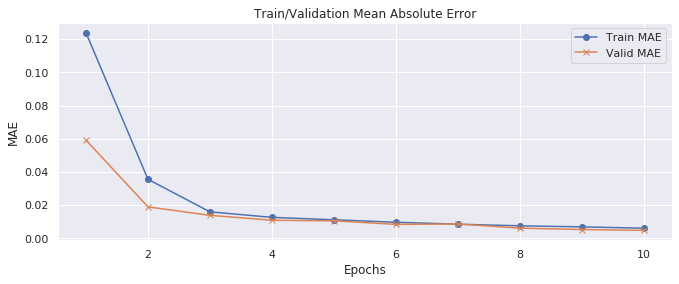

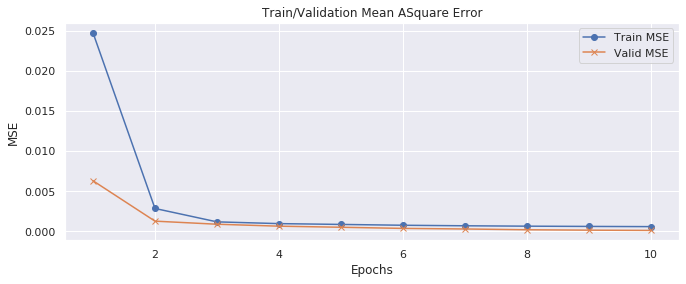

In [34]:
f, ax = plt.subplots()
ax.plot([None] + gru.history.history['loss'], 'o-' )
ax.plot([None] + gru.history.history['val_loss'], 'x-')

ax.legend(['Train MAE', 'Valid MAE'], loc=1)
ax.set_title('Train/Validation Mean Absolute Error')
ax.set_xlabel('Epochs')
ax.set_ylabel('MAE')
f.show()

f, ax = plt.subplots()
ax.plot([None] + gru.history.history['mean_squared_error'], 'o-' )
ax.plot([None] + gru.history.history['val_mean_squared_error'], 'x-')

ax.legend(['Train MSE', 'Valid MSE'], loc=1)
ax.set_title('Train/Validation Mean ASquare Error')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')
f.show()

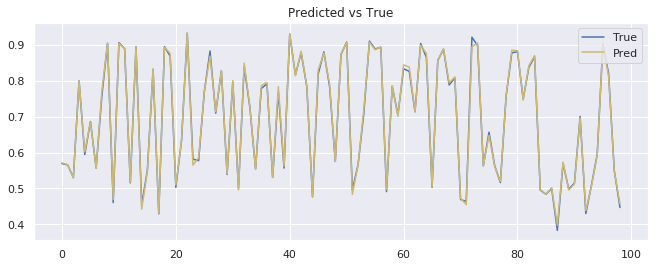

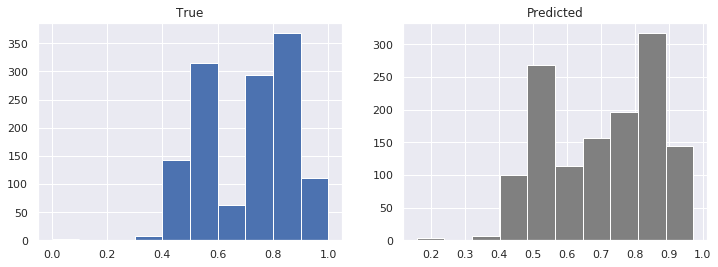

In [35]:
plt.plot(y_test_df1[1:100], 'b')
plt.plot( predict[1:100], 'y')
plt.legend(['True', 'Pred'],loc=1)
plt.title('Predicted vs True')
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(y_test_df1)
plt.title('True')

plt.subplot(1,2,2)
plt.hist(predict, color='grey')
plt.title('Predicted')
plt.show()

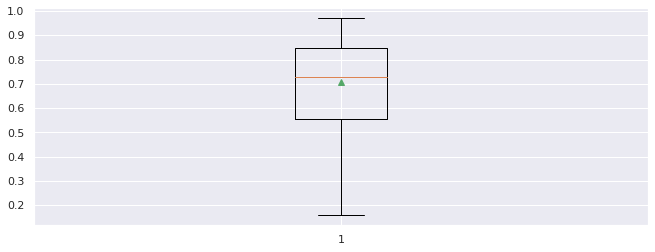

In [36]:
plt.boxplot(predict, showmeans=True)
plt.show()

## Time Based Prediction Plot

In [37]:
true = out_scaler.inverse_transform([y_test_df1]) # true values without scaling
result = out_scaler.inverse_transform(predict)  # predicted values without scaling

In [38]:
tm = in_scaler.inverse_transform(x_test_df1)  # descaling test input values

In [39]:
tm1 = tm[:,3]   # descaling Test set Day values
tm2 = tm[:,4]   # descaling Test set Month values
tm3 = tm[:,5]   # descaling Test set Year values
tm4 = tm[:,6]   # descaling Test set Hour values

In [40]:
# Result DataFrame without scaled values for true and predicted
res = pd.DataFrame()
res['Hour'] = tm4.astype(int)
res['Day'] = tm1.astype(int)
res['Month'] = tm2.astype(int)
res['Year'] = tm3.astype(int)
res['True'] = np.squeeze(true)
res['Predicted'] = np.squeeze(result)
res['Time'] = res['Hour'].map(str) +'-' + res['Day'].map(str) +'-' +res['Month'].map(str) +'-' + res['Year'].map(str)

In [41]:
# Sorting result values according to time in ascending order and resetting index
res1 = res.sort_values(by=['Year','Month','Day','Hour'])
res1 = res1.reset_index(drop=True)

In [42]:
res1.head()

,Hour,Day,Month,Year,True,Predicted,Time
0,11,2,11,2012,11426.65,11415.634766,11-2-11-2012
1,15,2,11,2012,11465.05,11450.593750,15-2-11-2012
2,9,3,11,2012,12115.60,12093.923828,9-3-11-2012
3,12,3,11,2012,12101.70,12068.684570,12-3-11-2012
4,9,4,11,2012,12124.40,12062.997070,9-4-11-2012


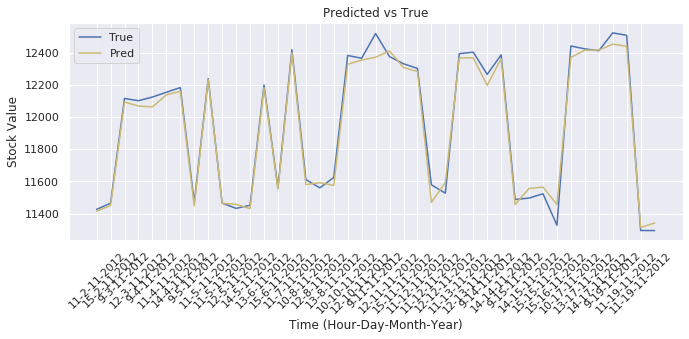

In [43]:
# First 40 Test Set Points Plot
plt.plot(res1.loc[:40,'True'], 'b')
plt.plot( res1.loc[:40,'Predicted'], 'y')
plt.legend(['True', 'Pred'])
plt.title('Predicted vs True')
# for displaying day time x-axis labels uncomment the next line
plt.xticks(ticks=np.arange(40), labels=res1.loc[:40,'Time'], rotation = 45)
plt.ylabel('Stock Value')
plt.xlabel('Time (Hour-Day-Month-Year)')
plt.show()

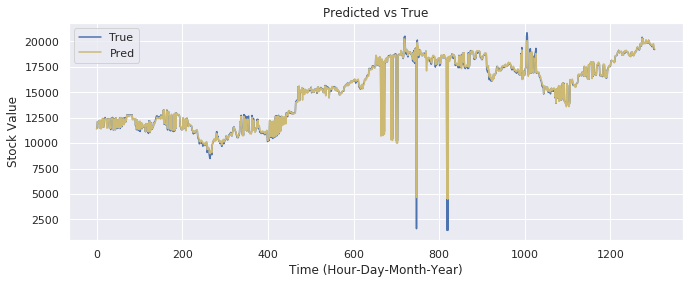

In [44]:
# Complete Test Set Plot
plt.plot(res1['True'], 'b')
plt.plot( res1['Predicted'], 'y')
plt.legend(['True', 'Pred'])
plt.title('Predicted vs True')
plt.ylabel('Stock Value')
plt.xlabel('Time (Hour-Day-Month-Year)')
plt.show()